In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import qiskit
from functools import reduce
import time
import pickle


In [2]:
def pauli_str_to_unitary(pstr):
    def char_to_pauli(c):
        if c == "I":
            return np.eye(2)
        elif c == "X":
            return np.array([[0, 1], [1, 0]])
        elif c == "Y":
            return np.array([[0, -1j], [1j, 0]])
        elif c == "Z":
            return np.array([[1, 0], [0, -1]])
        else:
            raise ValueError(f"Invalid Pauli character: {c}")
    
    return reduce(np.kron, [char_to_pauli(c) for c in pstr], np.array([[1]]))

In [3]:
def spin_chain_H(n, J=1, g=1, type="transverse"):
    d = 2**n
    if type == "transverse":
        Hzz, Hx = np.zeros((d, d)), np.zeros((d, d))
        for i in range(n):
            if i < n-1:
                pstr = list("I"*n)
                pstr[i] = pstr[i+1] = "Z"
                Hzz += pauli_str_to_unitary(pstr)
            
            pstr = list("I"*n)
            pstr[i] = "X"
            Hx += pauli_str_to_unitary(pstr)

        Hzz *= -J
        Hx *= -J*g # h = -J*g
        H = Hzz + Hx

    return H, [Hzz, Hx]

In [4]:
def rand_prod_state(n):
    def rand_state():
        return qiskit.quantum_info.random_statevector(2)

    return reduce(np.kron, [rand_state() for _ in range(n)], np.array(1))

In [5]:
def expect(state, H):
    if state.ndim == 1:
        res = state.conj().T @ H @ state
    else:
        rho = state
        res = np.trace(rho @ H)
    
    assert np.isclose(res.imag, 0)
    return res.real # real-valued observables

def outer(state):
    psi = state.reshape(-1, 1)
    return psi @ psi.conj().T

def trdist(rho, sigma):
    return np.sum(np.abs(np.linalg.svdvals(rho-sigma))) / 2

def spin_cov(rho, spin_ind):
    n = int(np.log2(rho.shape[0]))
    pstr = list('I'*n)
    pstr[spin_ind] = 'X'
    expect_Xi = expect(rho, pauli_str_to_unitary(pstr))
    pstr[spin_ind+1] = 'X'
    expect_XiXiplus1 = expect(rho, pauli_str_to_unitary(pstr))
    pstr[spin_ind] = 'I'
    expect_Xiplus1 = expect(rho, pauli_str_to_unitary(pstr))
    spin_cov = expect_XiXiplus1 - expect_Xi*expect_Xiplus1
    return spin_cov

In [6]:
gcauchy_pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4)

def sample_gcauchy(beta, M=1):
    cs = []
    # pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4) ~ C_{1/sqrt2}^4
    thresh = (1+np.sqrt(5))/2 # sup u of pdf(u)/cauchypdf(u) = golden ratio
    while len(cs) < M:
        c = scipy.stats.cauchy.rvs()
        u = scipy.stats.uniform.rvs()
        h = (1+c**2)/(1+(c/np.sqrt(2))**4)
        if u < h/thresh:
            cs.append(c)

    return beta*(np.array(cs) if M > 1 else cs[0])

def gcauchy_pdf(beta):
    pdf = lambda u: 1/np.pi * 1/(1+(u/np.sqrt(2))**4)
    return lambda u: 1/beta * pdf(u/beta)

In [7]:
class Hamiltonian:
    def __init__(self, H, Hs=[], steps=0, order=1):
        if steps == 0:
            Hs = [H]
            steps = 1
            order = 1
        
        self.H = H
        self.Hs = Hs 
        self.n = self.Hs[0].shape[0]
        self.steps = steps
        self.order = order

        self.Us = []
        self.Ds = []
        self.lams = []
        for Hi in self.Hs:
            eigenvals, eigenvecs = np.linalg.eigh(Hi)
            self.Us.append(eigenvecs)
            self.Ds.append(np.diag(eigenvals))
            self.lams.append(eigenvals)
        
        eigenvals, eigenvecs = np.linalg.eigh(self.H)
        self.U = eigenvecs
        self.D = np.diag(eigenvals)
        self.lam = eigenvals
        self.ground = eigenvecs[:, 0]
    
    
    # e^{alpha H_i}
    def term(self, i, alpha, method="fast"):
        if "direct" in method:
            return scipy.linalg.expm(self.Hs[i] * alpha)
        elif "fast" in method:
            return self.Us[i] @ np.diag(np.exp(self.lams[i] * alpha)) @ self.Us[i].conj().T
        else:
            raise ValueError(f"Invalid method: {method}")
    
    # e^{alpha H_i} via a trotter formula
    def trotter(self, alpha, method="fast"):
        def S(x, o):
            assert o > 0 and (o == 1 or o%2 == 0)
            init = np.identity(self.n)
            if o == 1:
                terms = [self.term(i, x, method=method) for i in range(len(self.Hs))]
                return reduce(lambda A, B: A @ B, terms, init) 
            elif o == 2:
                terms = [self.term(i, x/2, method=method) for i in range(len(self.Hs))]
                return reduce(lambda A, B: A @ B, terms, init) @ reduce(lambda A, B : B @ A, terms, init)
            else:
                p = 1.0 / (4 - 4**(1.0 / (o - 1)))
                return S(p*x, o - 2) @ S((1-2*p)*x, o-2) @ S(p*x, o-2)
            
        res = np.linalg.matrix_power(S(alpha/self.steps, self.order), self.steps)
        return res
    
    def ITE(self, beta, method="fast"):        
        return self.trotter(-beta, method=method)

    def RTE(self, t, method="fast"):
        return self.trotter(-1j * t, method=method)
    
    def iITE(self, state, beta, method="fast"):
        psi_ = self.ITE(beta, method=method) @ state
        psi = psi_ / np.linalg.norm(psi_)
        return psi

    def iITE_rand_iRTE(self, state, beta, M = 1000, sample=sample_gcauchy, pdf=gcauchy_pdf, method="fast", **kwargs):
        method2 = "direct" if "direct" in method else "fast"
        psi = self.iITE(state, beta, method=method2)

        if method == "direct":
            samples = np.array([sample() for _ in range(M)])
            states = [self.RTE(t, method=method2) @ psi for t in samples]
            rho = sum([outer(s) for s in states]) / M
        elif method == "fast":
            # TODO: add trotterization in fast sample case
            assert len(self.Hs) == 1
            samples = np.array([sample() for _ in range(M)])
            c = self.U.conj().T @ psi
            phases = np.exp(-1j * np.outer(self.lam, samples))  # (n, M): phase factors exp(-i λ_i t_j)
            c_t = c[:, None] * phases                            # (n, M): c * exp(-i λ t_j)
            psi_t = self.U @ c_t                                  # (n, M): ψ_t = U @ c_t
            rho = psi_t @ psi_t.conj().T / M            # (1/M) Σ_j |ψ_t_j⟩⟨ψ_t_j|
        elif method == "integrate": 
            # \int dt p(t) e^{-iHt} e^{-\beta H} \rho_0 e^{-\beta H} e^{iHt} 
            # \int dt p(t) U e^{(-\beta-it) lam} U^dagger \rho_0 U e^{(-beta+it) lam} U^dagger
            # rho_0 = outer(psi)
            middle = [
                (np.identity(self.n) if i == 0 else self.Us[i-1].conj().T)
                @
                (np.identity(self.n) if i == len(self.Hs) else self.Us[i])
                for i in range(len(self.Hs)+1)
            ] # middle[i] = U[i] or U[i-1]^dagger U[i] or U[n-1].conj().T
            
            def integrand(t):
                psi_prime = self.RTE(t, method="fast") @ psi
                return pdf(t) * outer(psi_prime)
            
            rho = scipy.integrate.quad_vec(integrand, -np.inf, np.inf, **kwargs)[0]
        else:
            raise ValueError(f"Invalid method: {method}")
        
        return rho
    

In [8]:
# hamil = Hamiltonian(spin_chain_H(4)[0])

# psi0 = rand_prod_state(4)
# beta = 1

# # Time each method averaged over 10 runs
# times_integrate = []
# times_direct = []
# times_fast = []

# for _ in range(10):
#     start = time.time()
#     rho = hamil.iITE_rand_iRTE(psi0, beta, M=int(1e3), pdf=gcauchy_pdf(beta), method="integrate", epsrel=1e-4)
#     times_integrate.append(time.time() - start)
        
#     start = time.time()
#     rho_2 = hamil.iITE_rand_iRTE(psi0, beta, M=int(1e3), sample=lambda: sample_gcauchy(beta), method="direct") 
#     times_direct.append(time.time() - start)
    
#     start = time.time()
#     rho_3 = hamil.iITE_rand_iRTE(psi0, beta, M=int(1e3), sample=lambda: sample_gcauchy(beta), method="fast")
#     times_fast.append(time.time() - start)

# print(f"Average times:")
# print(f"Integrate: {np.mean(times_integrate):.3f}s")
# print(f"Direct: {np.mean(times_direct):.3f}s") 
# print(f"Fast: {np.mean(times_fast):.3f}s")


In [9]:
len(hamil.Hs)

NameError: name 'hamil' is not defined

In [10]:
n = 4
g = 1.4
J = 1.0
omega = 1.0
excited_ind = 0
H, Hs = spin_chain_H(n, J=J, g=g)
T = 1

psi0s = [rand_prod_state(n) for _ in range(T)]
memory = {}

In [11]:
# # Excited
# hamilH = Hamiltonian(H)
# omega = hamilH.lam[excited_ind] - (hamilH.lam[excited_ind] - hamilH.lam[excited_ind-1])*0.4
# Hp = H - omega * np.eye(2**n)
# Hp = Hp @ Hp 
# hamil = Hamiltonian(Hp)

steps, order = 0, 0 # Standard
# steps, order = int(1e3), 1 # Trotterized
# steps, order = int(1e3), 2 # Trotterized
# steps, order = int(1e3), 4
steps, order = int(1e3), 6
hamil = Hamiltonian(H, Hs, steps=steps, order=order)

Delta = hamil.lam[1] - hamil.lam[0]
spin_ind = 2

betas = np.linspace(0, 10, 20+1)[1:]
data = {'energies': dict(), 'spincov': dict(), 'trd': dict()}

method_names = ['iITE', 'iITE_rand_iRTE']
methods = [
    lambda *args: outer(hamil.iITE(*args, method="direct")),
    lambda psi0, beta: hamil.iITE_rand_iRTE(
        psi0, beta, M=int(1e3),
        sample=stats.norm(loc=0, scale=np.sqrt(2*beta/Delta)).rvs,
        pdf=stats.norm(loc=0, scale=np.sqrt(2*beta/Delta)).pdf,
        # pdf=gcauchy_pdf(beta),
        # pdf=stats.uniform(loc=0, scale=np.sqrt(2*beta/Delta)).pdf,
        method="integrate",
        # method="direct",
        epsrel=1e-6
    )
]

for mi, m in enumerate(methods):
    print(f"Method: {mi}")
    mn = method_names[mi]
    method = methods[mi]

    for psi0 in psi0s:
        d = {k: [] for k in data}
        for beta in betas:
            print(f"beta: {beta}")
            rho = method(psi0, beta)

            d['energies'].append(expect(rho, H))
            d['trd'].append(trdist(rho, outer(hamil.U[:,excited_ind])))

            d['spincov'].append(spin_cov(rho, spin_ind))
        
        for k in data:
            if mn not in data[k]: data[k][mn] = []
            data[k][mn].append(d[k])

    for k in data: data[k][mn] = np.array(data[k][mn])

memory[(steps, order)] = data


Method: 0
beta: 0.5
beta: 1.0
beta: 1.5
beta: 2.0
beta: 2.5
beta: 3.0
beta: 3.5
beta: 4.0
beta: 4.5
beta: 5.0
beta: 5.5
beta: 6.0
beta: 6.5
beta: 7.0
beta: 7.5
beta: 8.0
beta: 8.5
beta: 9.0
beta: 9.5
beta: 10.0
Method: 1
beta: 0.5
beta: 1.0
beta: 1.5
beta: 2.0
beta: 2.5
beta: 3.0
beta: 3.5
beta: 4.0
beta: 4.5
beta: 5.0
beta: 5.5
beta: 6.0
beta: 6.5
beta: 7.0
beta: 7.5
beta: 8.0
beta: 8.5
beta: 9.0
beta: 9.5
beta: 10.0


Slope for iITE: -1.368
Slope for iITE_rand_iRTE: -2.735
Slope for iITE: -0.457
Slope for iITE_rand_iRTE: -0.883
Slope for iITE: -1.127
Slope for iITE_rand_iRTE: -1.185
Slope for iITE: -1.293
Slope for iITE_rand_iRTE: -1.470
Slope for iITE: -1.363
Slope for iITE_rand_iRTE: -1.777


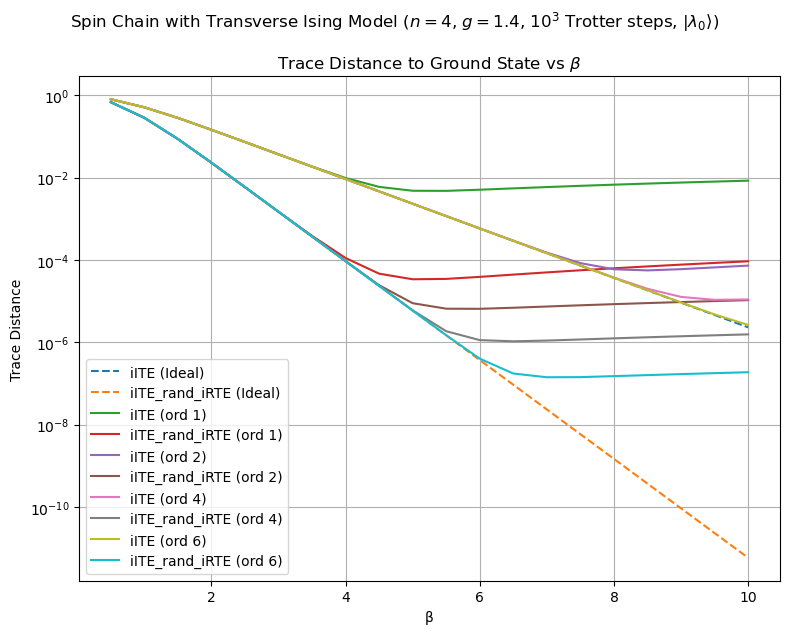

In [178]:
def energy_plot(ax, data, method_names, betas):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        ax.plot(betas, np.mean(data['energies'][method], axis=0), linestyle, label=method)
    ax.set_xlabel('β')
    ax.set_ylabel(r'Energy $\langle \psi | H | \psi \rangle$')
    ax.set_title(r'Energy vs $\beta$')
    ax.legend()
    ax.grid(True)

def trd_plot(ax, data, method_names, betas, suffix="", linestyle='-'):
    for method in method_names:
        # linestyle = '-' if method == 'iITE' else '--'
        y_data = np.mean(data['trd'][method], axis=0)
        ax.plot(betas, y_data, linestyle, label=method + " " + suffix)
        
        def fit_func(x, m, b):
            return m * x+b
            
        params, _ = scipy.optimize.curve_fit(fit_func, betas, np.log(y_data))
        fit_line = np.exp(fit_func(betas, *params))
        # ax.plot(betas, fit_line, '--', alpha=0.5,
        #         label=f'{method} np.exp({params[0]:.3f}*x+{params[1]:.3f})')
        print(f"Slope for {method}: {params[0]:.3f}")
        
    ax.set_xlabel('β')
    ax.set_ylabel(r'Trace Distance')
    ax.set_title(r'Trace Distance to Ground State vs $\beta$')
    ax.set_yscale('log')
    
    ax.legend()
    ax.grid(True)

def spincov_plot(ax, data, method_names, betas):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        ax.plot(betas, np.mean(data['spincov'][method], axis=0), linestyle, label=f'{method} at i = {spin_ind}')
    ax.set_xlabel('β')
    ax.set_ylabel(r'Spin Covariance')
    ax.set_title(r'Spin Covariance vs $\beta$')
    ax.legend()
    ax.grid(True)

def spincov_rel_err_plot(ax, data, method_names, betas):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        # Calculate relative error for both correlation functions
        rel_err1 = np.abs(np.mean(data['spincov'][method], axis=0) - np.mean(data['spincov']['iITE'], axis=0)) / np.abs(np.mean(data['spincov']['iITE'], axis=0))
        
        if method != 'iITE':  # Skip plotting iITE vs itself
            ax.plot(betas, rel_err1, linestyle, label=f'Relative Error at i = {spin_ind}')
    ax.set_xlabel('β')
    ax.set_ylabel('Relative Error')
    ax.set_title('Relative Error in Spin Correlations (iITE_rand_iITE w.r.t. iITE)')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

fig, (ax1) = plt.subplots(1, 1, figsize=(8,6))
args = data, method_names, betas
# energy_plot(ax1, *args)

sorted_keys = sorted(memory.keys(), key=lambda x: x[1])
for k in sorted_keys:
    steps, order = k
    # if steps == 0: continue
    label = "(Ideal)" if steps == 0 else f"(ord {order})"
    trd_plot(ax1, memory[k], method_names, betas, suffix=label, linestyle='--' if steps == 0 else '-')
# spincov_plot(ax3, *args)
# spincov_rel_err_plot(ax3, *args)

plt.tight_layout()
plt.suptitle(rf'Spin Chain with Transverse Ising Model ($n = {n}$, $g = {g}$, '+rf'$10^{{{np.log10(steps):.0f}}}$ Trotter steps, '+ rf'$|\lambda_{excited_ind}\rangle$)', y=1.05)
plt.show()

In [148]:
np.log10(100)

np.float64(2.0)

In [ ]:
# Load data for different g values
g_values = [1.01, 1.3, 1.5, 1.7]
data_list = []

for g in g_values:
    fn = f'data_n{n}_g{g}_spin{spin_ind}_T{T}.pkl'
    with open(fn, 'rb') as f:
        data_list.append(pickle.load(f))

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, (g, data) in enumerate(zip(g_values, data_list)):
    for method in method_names:
        linestyle = '-' if method == 'iITE' else '--'
        ax.plot(betas, np.mean(data['trd'][method], axis=0), linestyle, 
                color=f'C{i}', label=f'{method} (g = {g})')

ax.set_xlabel('β')
ax.set_ylabel(r'Trace Distance')
ax.set_title(f'Trace Distance vs $\\beta$ for Different g Values')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.suptitle(f'Trace Distance Comparison (n = {n})', y=1.05)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data_n4_g1.01_spin2_T1.pkl'